<a href="https://colab.research.google.com/github/Starksood/Experimental_Conundrums/blob/main/Ch11_Sequence_Models(Conv_and_Recc).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Reading GISS data in python

In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/station.csv \
    -O /tmp/station.csv

--2021-12-18 19:06:08--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/station.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6979 (6.8K) [application/octet-stream]
Saving to: ‘/tmp/station.csv’

/tmp/station.csv    100%[===================>]   6.82K  --.-KB/s    in 0s      

2021-12-18 19:06:09 (34.0 MB/s) - ‘/tmp/station.csv’ saved [6979/6979]



In [6]:
def get_data():
  data_file = "/tmp/station.csv"
  f = open(data_file)
  data = f.read()
  f.close()
  lines = data.split('\n')
  header = lines[0].split(',')
  lines = lines[1:]
  temperatures=[]
  for line in lines:
    if line:
      linedata = line.split(',')
      linedata = linedata[1:13]
      for item in linedata:
        if item:
          temperatures.append(float(item))
  series = np.asarray(temperatures)
  time = np.arange(len(temperatures), dtype="float32")
  return time, series        

This will open the file at the indicated path (yours will of course differ) and read in
the entire file as a set of lines, where the line split is the new line character (\n). It will
then loop through each line, ignoring the first line, and split them on the comma
character into a new array called linedata. The items from 1 through 13 in this array
will indicate the values for the months January through February as strings. These
values are converted to floats and added to the array called temperatures. Once it’s
completed it will be turned into a Numpy array called series, and another Numpy.
array called time will be created that’s the same size as series. As it is created using
np.arange, the first element will be 1, the second 2, etc. Thus, this function will
return time in steps from 1 to the number of data points, and series as the data for
that time.
Now if you want a time series that is normalized, you can simply run this code:

In [12]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [16]:
time, series = get_data()
mean = series.mean(axis=0)
series-=mean
std = series.std(axis=0)
series/=std
split_time = 780
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

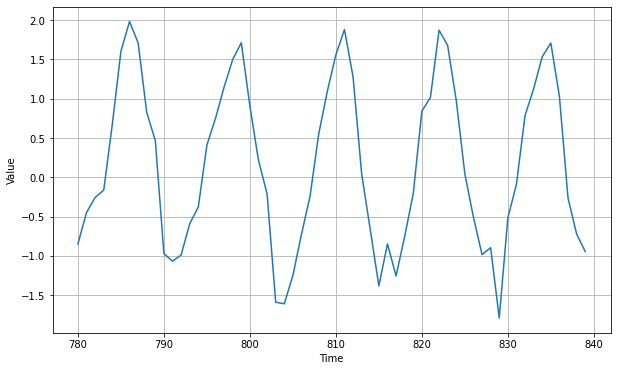

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [18]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset



In [20]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
# Experiment with this to play with accuracy. Do note that
# this is a small dataset, so a large window size may
# cause errors.
window_size = 40
batch_size = 20
shuffle_buffer_size = 20

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True, dropout=0.1, recurrent_dropout=0.1)),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1)), 
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=50,  verbose=1, validation_data=valid_dataset)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
37/37 [==============================] - 23s 344ms/step - loss: 0.4499 - mae: 0.8590 - val_loss: 0.5288 - val_mae: 0.9583
Epoch 2/50
37/37 [==============================] - 11s 307ms/step - loss: 0.4479 - mae: 0.8571 - val_loss: 0.5266 - val_mae: 0.9560
Epoch 3/50
37/37 [==============================] - 11s 305ms/step - loss: 0.4460 - mae: 0.8545 - val_loss: 0.5245 - val_mae: 0.9538
Epoch 4/50
37/37 [==============================] - 11s 307ms/step - loss: 0.4429 - mae: 0.8504 - val_loss: 0.5223 - val_mae: 0.9515
Epoch 5/50
37/37 [==============================] - 11s 310ms/step - loss: 0.4409 - mae: 0.8482 - val_loss: 0.5201 - val_mae: 0.9493
Epoch 6/50
37/37 [==============================] - 12s 311ms/step - loss: 0.4384 - mae: 0.8455 - val_loss: 0.5180 - val_mae: 0.9470
Epoch 7/50
37/37 [==============================] - 12s 323ms/step - loss: 0.4361 - mae: 0.8429 - val_loss: 0.5158 - val_mae: 0.9447
Epoch 8/50
37/37 [==============================] - 11s 307ms/step - 

In [21]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [22]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

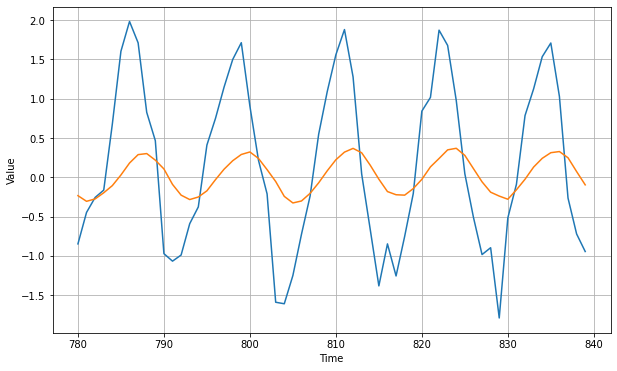

In [23]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [25]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()
print(mae)

0.7986915


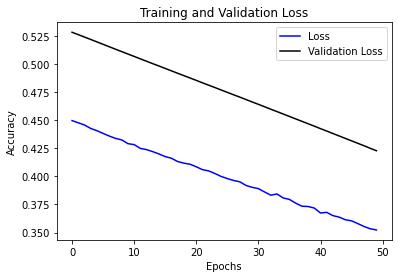

<Figure size 432x288 with 0 Axes>

In [26]:
mae=history.history['mae']
loss=history.history['loss']
val_mae=history.history['val_mae']
val_loss=history.history['val_loss']
epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
#plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
#plt.plot(epochs, val_mae, 'g')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()